# Technical Methodology - Adapting to a Rising Sea: A Case Study in Coastal Management under Climate Change 

## Abstract
Coastal erosion is a pressing global issue, posing significant threats to coastal communities, infrastructure, and ecosystems. While climate change has occurred naturally in the past, human activities have significantly expedited the process since the 1800s through the burning of fossil fuels. Elevated global temperatures tend to induce a substantial decline in glaciers and ice sheets resulting in the addition of significant volumes of water to the world's oceans. Furthermore, thermal expansion of seawater due to warming amplifies this effect, contributing to a net rise in global sea level. The escalating sea level poses a grave threat to coastal communities, as it exacerbates seasonal tidal inundation events, potentially submerging infrastructure and even entire islands. While erosion management techniques are deployed to mitigate these impacts, the efficacy of such measures under a changing climate necessitates rigorous evaluation. This study uses Digital Earth Africa (DEA) Landsat Imagery Services and geospatial tooling to investigate the impact of the Atorkor-Dzita-Anyanui and Keta Sea Defense Project on shoreline change along the Dzita coast; southeastern of Ghana, quantifying the rate of shoreline change and exploring the relationship between shoreline retreat/accretion patterns, and climate change-induced sea-level rise over the past two decades. Prior to the implementation of sea defenses, the coastline experienced significant erosion. However, following the construction of seawalls, shoreline retreat slowed considerably, and in some areas, substantial accretion was observed. This suggests that the seawalls have effectively mitigated erosion in certain locations.

While the Keta Sea Defense Project has proven successful in protecting specific areas, it has inadvertently exacerbated down-drift erosion along Kedzi and Hlorve (East of Keta). This unintended consequence highlights the complex interactions between coastal defense structures and natural shoreline processes, underscoring the need for comprehensive and adaptive coastal management strategies. Correlation analysis between shoreline change and sea level rise yielded inconclusive results, suggesting a quasi-linear relationship between the variables indicating the complex interplay of other factors such as human activities and sediment dynamics influencing coastal erosion. The findings of this study underscore the critical need for data-driven, adaptive coastal management strategies. By quantifying the impact of the sea defense projects and highlighting the complex interplay between shoreline change and sea level rise, this research provides valuable insights for policymakers and coastal communities; emphasizing the importance of investing in coastal protection infrastructure, while also recognizing the need for long-term adaptation measures to address the escalating challenges posed by climate change

### DE Africa use case
[Landsat](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_C2_SR_specs.html) images can be used to study coastal areas, but their effectiveness can be limited by factors like clouds, sunlight reflecting off the water, poor water conditions, and tides. To address these issues, multiple images can be combined to create clearer composite images, and filters can be applied to focus on images taken at specific tidal times. These improved images can then be used to accurately determine the exact boundary between land and water, allowing for the measurement of shoreline changes over time.


### Disclaimer
The workflow demonstrated in this notebook is an adaptation of [Bishop-Taylor et al. (2021b)](https://doi.org/10.1016/j.rse.2021.112734) using the open data cube [(Dhu et al., 2019)](https://doi.org/10.3390/data4040144), xarray (Hoyer & Hamman, 2017), dea-tools (Krause et al., 2021) and [dea-coastlines](https://github.com/digitalearthafrica/deafrica-coastlines) (Bishop-Taylor et al., 2021a) python packages to extract analysis-ready Landsat 7 satellite data from the Digital Earth datacube as adapted from the [DE Africa jupyter notebook example on coastal erosion analysis](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Real_world_examples/Coastal_erosion.ipynb).

In this workflow, a simplified version of the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) method is used to combine time series data with image compositing and tide filtering techniques to accurately map shorelines across time, and identify changes using Landsat 7 imagery.

### Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**NB:** This notebook was run using the [DEA sandbox service](https://sandbox.digitalearth.africa/). In order to replicate the steps outlined here, it is advisable to download this notebook and upload it into a DEA sandbox service server to avoid any unexpected errors.

### Load packages
Firstly, additional tools from the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) repository needed to estimate rates of coastal change need to be downloaded. 

In [40]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git@S2_test --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


Now key Python packages and supporting functions for the analysis are loaded.

In [41]:
%matplotlib inline

import warnings

import datacube
import rioxarray
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from skimage.filters import threshold_minimum

import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from datacube.utils.geometry import Geometry

warnings.filterwarnings("ignore")

from coastlines.raster import load_tidal_subset, tide_cutoffs
from coastlines.vector import annual_movements, calculate_regressions, points_on_line
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import pixel_tides
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, load_best_available_ds, preprocess_s1
from deafrica_tools.plotting import display_map, rgb, xr_animation
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.areaofinterest import define_area

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [42]:
client = create_local_dask_cluster(return_client=True)

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41267
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:42895
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45719'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45743', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45743
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40890
INFO:distributed.scheduler:Receive client connection: Client-ab31895b-7d97-11ef-8063-1e4c2102f351
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40898


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jdkudadjie@outlook.com/proxy/42895/status,
Dashboard: /user/jdkudadjie@outlook.com/proxy/42895/status,Workers: 1
Total threads: 2,Total memory: 11.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41267,Workers: 1
Dashboard: /user/jdkudadjie@outlook.com/proxy/42895/status,Total threads: 2
Started: Just now,Total memory: 11.21 GiB
Comm: tcp://127.0.0.1:45743,Total threads: 2
Dashboard: /user/jdkudadjie@outlook.com/proxy/45007/status,Memory: 11.21 GiB
Nanny: tcp://127.0.0.1:45719,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [43]:
dc = datacube.Datacube(app="Coastal_erosion_analysis")

### Select location
The study area is selected by uploading a polygon (`GeoJSON or Esri Shapefile with all its related files - .cpg, .dbf, .shp, .shx.`) which covers the intended area of study.


In [44]:
#Use a polygon as a GeoJSON or Esri Shapefile. 
aoi = define_area(vector_path='dzita_beach_shoreline.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:32630")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

#!remove?
# Set the range of dates for the analysis, time step and tide range
#This parameter allows us to choose the length of the time periods we want to compare: 
#e.g. shorelines for each year, or shorelines for each six months etc. `1Y` will generate 
#one coastline for every year in the dataset; `2Y` will produce a coastline for every two years, etc.
time_step = "1Y"


### View the selected location
Display the selected area on an interactive map.

In [45]:
display_map(x=lon_range, y=lat_range)

## Load Satellite Product
The first step in this analysis is to select from the available satellite imagery products (Landsat 7 in this case, due to wide coverage and imagery consistency over the intended years of study) and load the best available one for shoreline mapping at the given location and study period.

The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple Landsat satellites by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function.

Here we use the function `load_ard`([See documentation](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Frequently_used_code/Using_load_ard.ipynb)), to select and load the data with the following parameters:

* `dc`: initiated datacube
* `products`: satellite product
* `measurements`: satellite product bands
* `output_crs`: intended crs
* `x` and `y`: lat and long range coordinates of polygon
* `time`: time period
* `resolution`: satellite product resolution



Note: Depending on parameter setting, **the cell below may take more than 10 minutes to finish**. 

In [46]:
#load landsat 7 data
product_name = "ls"
ds_selected = load_ard(dc=dc,
              products=["ls7_sr"],
              measurements=['red', 'green', 'blue','swir_1'],
             output_crs='EPSG:32630',
            y=lat_range,
            x=lon_range,
            time=("2001-01", "2024-01"),
              resolution=(-30, 30),
              group_by="solar_day"
             )
print(product_name, "\n", ds_selected)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls7_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 530 time steps


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


ls 
 <xarray.Dataset>
Dimensions:      (time: 530, y: 15, x: 106)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-30T10:00:00.977702 ... 2024-01...
  * y            (y) float64 6.395e+05 6.394e+05 ... 6.391e+05 6.39e+05
  * x            (x) float64 9.165e+05 9.165e+05 ... 9.196e+05 9.196e+05
    spatial_ref  int32 32630
Data variables:
    red          (time, y, x) float32 0.1417 0.1438 0.1396 ... 0.1314 0.1244
    green        (time, y, x) float32 0.1243 0.1243 0.1243 ... 0.1338 0.1418
    blue         (time, y, x) float32 0.1034 0.1056 0.09893 ... 0.1332 0.1332
    swir_1       (time, y, x) float32 0.2615 0.2615 0.2512 ... 0.05916 0.07695
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref


## Process data and generate annual composites

### Model tide height  
The satellite imagery received includes images captured at different tide levels, so it is essential to filter out those taken at undesirable tide heights. This is accomplished by using computational python functions based on the FES2014 tidal model (Carrere et al., 2016) limiting the selection to images taken around mid-tide (zero meters above mean sea level) for further analysis.

For each satellite timestep, the `pixel_tides` function is used to model tide heights into a low-resolution 5 x 5 km grid (matching resolution of the [FES2014 tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)), then reprojects modelled tides into the spatial extent of the satellite image. This new data is then added as a new variable `tide_m` in the satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [47]:
ds_selected["tide_m"], tides_lowres = pixel_tides(ds_selected, resample=True)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 530/530 [00:01<00:00, 273.41it/s]


Based on the entire time-series of tide heights, the max and min satellite-observed tide height for each pixel is computed, then  tide cutoffs calculated is used to restrict the data to satellite observations centred over mid-tide (0 m Above Mean Sea Level) using the tide_cutoffs function:

In [48]:
# Determine tide cutoff
tide_cutoff_min, tide_cutoff_max = tide_cutoffs(ds_selected, tides_lowres, tide_centre=0.0)

With the tide cutoffs calculated for all pixels, now only observations within the tide height cutoff ranges are kept. Also, time-steps with no pixels within the cutoff ranges are dropped:

In [49]:
tide_bool = (ds_selected.tide_m >= tide_cutoff_min) & (ds_selected.tide_m <= tide_cutoff_max)
ds_selected = ds_selected.sel(time=tide_bool.sum(dim=["x", "y"]) > 0)

# Apply mask, and load in corresponding tide masked data
ds_selected = ds_selected.where(tide_bool)
print(ds_selected)

<xarray.Dataset>
Dimensions:      (time: 344, y: 15, x: 106)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-30T10:00:00.977702 ... 2024-01...
  * y            (y) float64 6.395e+05 6.394e+05 ... 6.391e+05 6.39e+05
  * x            (x) float64 9.165e+05 9.165e+05 ... 9.196e+05 9.196e+05
    spatial_ref  int32 32630
Data variables:
    red          (time, y, x) float32 0.1417 0.1438 0.1396 ... 0.1314 0.1244
    green        (time, y, x) float32 0.1243 0.1243 0.1243 ... 0.1338 0.1418
    blue         (time, y, x) float32 0.1034 0.1056 0.09893 ... 0.1332 0.1332
    swir_1       (time, y, x) float32 0.2615 0.2615 0.2512 ... 0.05916 0.07695
    tide_m       (time, y, x) float32 -0.04703 -0.04703 ... 0.1369 0.1369
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref


### Process selected data
To extract shoreline positions, it is necessary to distinguish land from water. By using a computation based on the Modified Normalized Difference Water Index [(Xu, 2006)](https://doi.org/10.1080/01431160600589179), the presence of water is identified by calculating the ratio between green and shortwave-infrared (SWIR) radiation by using Landsat’s green and SWIR 1 bands.

The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{SWIR})}{(\text{Green} + \text{SWIR})}
\end{aligned}
$$

where `Green` is the green band and `SWIR` is the SWIR band. 

In [50]:
 # Calculate the water index
ds_selected = calculate_indices(ds_selected, index="MNDWI", satellite_mission="ls")

### Combine observations into noise-free summary images
Remote sensing images often contain noise, such as clouds or cloud shadows in optical images and wind effects on water in radar images. To generate clearer imagery that allow for easier comparison over time, composite or 'summary' images are created by merging multiple images into one. These composites capture the median or 'typical' view of the landscape during a specific time frame and the median is chosen to avoid distortion of the data by extreme outliers.

The time series of images are combined into single images for each `time_step`. For example, if `time_step = '1Y'`, the code will produce one new image for each year in the dataset.

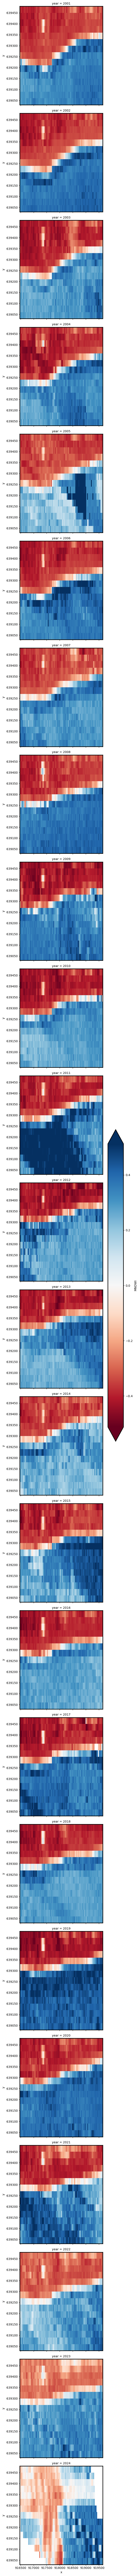

In [51]:
# Combine into summary images by `time_step`
if (product_name == "ls"):
    var = "MNDWI"
else:
    var = "vh"


ds_summaries = ds_selected[[var]].resample(time=time_step).median("time").compute()
# Rename time attribute as year
ds_summaries["time"] = ds_summaries.time.dt.year
ds_summaries = ds_summaries.rename(time="year")

# Plot the output summary images
ds_summaries[var].plot(col="year", cmap="RdBu", col_wrap=1, robust=True, size=5)


plt.show()

In [52]:
# Shut down Dask client now that we have processed the data we need
client.close()

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:45719'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:40890; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:45743', name: 0, status: closing, memory: 0, processing: 0>
INFO:distributed.core:Removing comms to tcp://127.0.0.1:45743
INFO:distributed.scheduler:Lost all workers
INFO:distributed.scheduler:Scheduler closing...
INFO:distributed.scheduler:Scheduler closing all comms


## Extract shorelines and calculate rates of coastal change 
### Extract shorelines from imagery
An accurate shoreline for each of the summary images above is now extracted. The code below identifies the boundary between land and water by tracing a line along pixels with a given threshold value. For Landsat and Sentinel-2 images, we use a water index value of `0`. 

The `subpixel_contours` function is used to identify the boundary between land and water by tracing a line along pixels with the previously identified threshold value. It returns a vector file with one line for each time step:


In [53]:
if (product_name == "ls"):
    threshold = 0
else:
    threshold = threshold_minimum(ds_selected[var].values[~np.isnan(ds_selected[var].values)])

contour_gdf = subpixel_contours(
    da=ds_summaries[var],
    z_values=threshold,
    dim="year",
    crs=ds_summaries.geobox.crs,
    output_path="annual_shorelines_{}.geojson".format(product_name),
    min_vertices=15,
)
contour_gdf = contour_gdf.set_index("year")
# Preview shoreline data
contour_gdf

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_ls.geojson


,geometry
year,
2001,"MULTILINESTRING ((916485.000 639237.812, 91651..."
2002,"MULTILINESTRING ((916485.000 639241.368, 91651..."
2003,"MULTILINESTRING ((916485.000 639237.842, 91651..."
2004,"MULTILINESTRING ((916815.000 639227.496, 91684..."
2005,"MULTILINESTRING ((916485.000 639242.956, 91651..."
2006,"MULTILINESTRING ((916485.000 639248.921, 91651..."
2007,"MULTILINESTRING ((916485.000 639253.693, 91651..."
2008,"MULTILINESTRING ((916485.000 639254.296, 91651..."
2009,"MULTILINESTRING ((916485.000 639274.426, 91651..."


### Plot resampled shorelines on an interactive map
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in black, and more recent shorelines in yellow.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, areas of coastline or rivers that have changed significantly over time or areas that have remained stable over the entire time period can be easily identified. 

**PS: Contour line data for the 2024 year was not accurately computed, hence it was removed from the final visualization and analysis**


In [54]:
# Plot shorelines on interactive map
bounds = np.arange(2001, 2024, 1)

contour_gdf.reset_index().explore(
    column="year",
    cmap="inferno",
    categorical=True,
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI WorldImagery",
)

### Calculate rates of coastal change
To identify parts of the coastline that are changing rapidly, annual shoreline data is used to calculate rates of coastal change in metres per year.

To do this,  a set of evenly spaced points at every 20 metres along the most recent shoreline need to be created. These points will be used to plot rates of coastal change across the study area.

<Axes: >

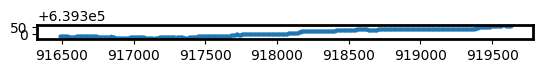

In [55]:
# Extract points at every 5 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index=2023, distance=5)
points_gdf.plot(markersize=3)

With a set of modelling points, distances from each of the points to each annual shoreline can be measured. 
This produces a table of distances, where negative values (e.g. `-6.5`) indicate that an annual shoreline was located inland of the points, and positive values (e.g. `2.3`) indicate a shoreline was located towards the ocean. Because the points were created along the most recent shoreline (2023 in this case since the 2024 line data was not optimal), distances for 2023 will always have a distance of 0 m.

In [56]:
# For each 5 m-spaced point, calculate the distance from
# the most recent 2023 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(
    points_gdf, contours_gdf=contour_gdf, yearly_ds=ds_summaries, baseline_year=2023, water_index=var
)
points_gdf

,geometry,dist_2001,dist_2002,dist_2003,dist_2004,dist_2005,dist_2006,dist_2007,dist_2008,dist_2009,...,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,dist_2022,dist_2023,dist_2024,angle_mean,angle_std
0,POINT (916485.000 639289.554),51.53,48.19,51.71,335.78,46.59,40.63,35.86,35.26,15.13,...,6.02,-7.46,-22.13,0.17,6.79,24.91,0.0,32.06,178,15
1,POINT (916490.000 639289.541),51.07,48.40,51.74,330.87,46.50,40.69,36.01,35.32,15.02,...,6.41,-6.60,-21.89,0.74,6.71,25.21,0.0,29.13,179,16
2,POINT (916495.000 639289.528),50.60,48.71,51.77,325.96,46.40,40.76,36.18,35.38,14.92,...,6.82,-5.74,-21.65,1.31,6.63,25.58,0.0,26.19,179,16
3,POINT (916500.000 639289.515),50.14,49.02,51.81,321.05,46.31,40.83,36.35,35.45,14.82,...,7.23,-4.89,-21.41,1.89,6.54,25.94,0.0,23.26,179,16
4,POINT (916505.000 639289.503),49.67,49.33,51.84,316.14,46.21,40.89,36.52,35.51,14.71,...,7.64,-4.03,-21.17,2.46,6.46,26.31,0.0,20.45,179,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,POINT (919609.498 639358.863),19.23,10.50,5.53,-1.90,-2.94,20.23,-3.98,13.79,21.73,...,275.29,-1.37,-8.47,-23.50,6.47,4.00,0.0,NaN,180,20
630,POINT (919614.481 639358.448),18.66,10.03,5.48,-2.34,-2.40,20.29,-4.38,12.75,21.39,...,280.23,-2.45,-9.15,-23.97,5.94,3.83,0.0,NaN,1,19
631,POINT (919619.464 639358.032),18.09,9.55,5.43,-2.77,-1.86,20.35,-4.78,11.71,21.05,...,285.17,-3.53,-9.83,-24.45,5.41,3.66,0.0,NaN,1,19
632,POINT (919624.446 639357.616),17.53,9.08,5.39,-3.21,-1.32,20.40,-5.17,10.67,20.71,...,290.11,-4.60,-10.51,-24.92,4.88,3.49,0.0,NaN,1,19


Finally, we can calculate annual rates of coastal change (in metres per year) using linear regression. 
This will add several new columns to our table:

* `rate_time`: Annual rates of change (in metres per year) calculated by linearly regressing annual shoreline distances against time (excluding outliers; see `outl_time`). Negative values indicate retreat and positive values indicate growth. 
* `sig_time`: Significance (p-value) of the linear relationship between annual shoreline distances and time. Small values (e.g. p-value < 0.01 or 0.05) may indicate a coastline is undergoing consistent coastal change through time. 
* `se_time`: Standard error (in metres) of the linear relationship between annual shoreline distances and time. This can be used to generate confidence intervals around the rate of change given by rate_time (e.g. 95% confidence interval = `se_time * 1.96`)
* `outl_time`: Individual annual shoreline are noisy estimators of coastline position that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea spray) or modelling issues (e.g. poor tidal modelling results or limited clear satellite observations). To obtain reliable rates of change, outlier shorelines are excluded using a robust Median Absolute Deviation outlier detection algorithm, and recorded in this column. 

In [57]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf, contours_gdf=contour_gdf)
points_gdf

,rate_time,sig_time,se_time,outl_time,dist_2001,dist_2002,dist_2003,dist_2004,dist_2005,dist_2006,...,dist_2018,dist_2019,dist_2020,dist_2021,dist_2022,dist_2023,dist_2024,angle_mean,angle_std,geometry
0,-2.042,0.001,0.539,2004,51.53,48.19,51.71,335.78,46.59,40.63,...,-7.46,-22.13,0.17,6.79,24.91,0.0,32.06,178,15,POINT (916485.000 639289.554)
1,-2.062,0.001,0.530,2004,51.07,48.40,51.74,330.87,46.50,40.69,...,-6.60,-21.89,0.74,6.71,25.21,0.0,29.13,179,16,POINT (916490.000 639289.541)
2,-2.081,0.001,0.525,2004,50.60,48.71,51.77,325.96,46.40,40.76,...,-5.74,-21.65,1.31,6.63,25.58,0.0,26.19,179,16,POINT (916495.000 639289.528)
3,-2.101,0.001,0.521,2004,50.14,49.02,51.81,321.05,46.31,40.83,...,-4.89,-21.41,1.89,6.54,25.94,0.0,23.26,179,16,POINT (916500.000 639289.515)
4,-2.119,0.001,0.519,2004,49.67,49.33,51.84,316.14,46.21,40.89,...,-4.03,-21.17,2.46,6.46,26.31,0.0,20.45,179,15,POINT (916505.000 639289.503)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,-0.638,0.189,0.470,2017 2024,19.23,10.50,5.53,-1.90,-2.94,20.23,...,-1.37,-8.47,-23.50,6.47,4.00,0.0,NaN,180,20,POINT (919609.498 639358.863)
630,-0.650,0.186,0.474,2017 2024,18.66,10.03,5.48,-2.34,-2.40,20.29,...,-2.45,-9.15,-23.97,5.94,3.83,0.0,NaN,1,19,POINT (919614.481 639358.448)
631,-0.672,0.173,0.476,2017 2024,18.09,9.55,5.43,-2.77,-1.86,20.35,...,-3.53,-9.83,-24.45,5.41,3.66,0.0,NaN,1,19,POINT (919619.464 639358.032)
632,-0.690,0.165,0.479,2017 2024,17.53,9.08,5.39,-3.21,-1.32,20.40,...,-4.60,-10.51,-24.92,4.88,3.49,0.0,NaN,1,19,POINT (919624.446 639357.616)


### Plot rates of coastal change on an interactive map
Now that the calculated rates of coastal change have been produced, these can be plotted on an interactive map to identify parts of the coastline that are retreating or growing over time.

In [58]:
# Add human-friendly label for plotting
points_gdf["Coastal change"] = points_gdf.apply(
    lambda x: f'<h4>This coastline has {"<b>retreated</b>" if x.rate_time < 0 else "<b>grown</b>"} '
    f"by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since "
    f"<b>{contour_gdf.index[0]}</b></h4>",
    axis=1,
)
points_gdf.loc[points_gdf.sig_time > 0.05, "Coastal change"] = f"<h4>No significant trend of retreat or growth)</h4>"

# Add annual shorelines to map
m = contour_gdf.reset_index().explore(
    column="year",
    cmap="inferno",
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    tooltip=False,
    style_kwds={"opacity": 0.5},
    attr="ESRI WorldImagery",
    categorical=True,
)

# Add rates of change to map
points_gdf.explore(m=m, column="rate_time", vmin=-5, vmax=5, tooltip="Coastal change", cmap="RdBu")

> **Important note:** This notebook may produce misleading rates of change for non-coastal waterbodies that might fluctuate naturally year-by-year.
The full [Digital Earth Africa Coastlines repository](https://github.com/digitalearthafrica/deafrica-coastlines.git) contains additional methods for producing more accurate rates of change by cleaning and filtering annual shoreline data to focus only on coastal shorelines.

### Export rates of change to file
Finally, the rates of change file can be exported so that it can be loaded in GIS software (e.g. ESRI ArcGIS or QGIS).

In [59]:
points_gdf.to_crs("EPSG:32630").to_file("rates_of_changes_{}.geojson".format(product_name))

## Plot annual shorelines animated GIF

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Compatible datacube version:**

In [60]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [61]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2024-09-28'